In [1]:
import argparse
import sys
import math
import torch
import gpytorch
import numpy as np
import spectralgp
from custom_plotting import plot_predictions_real_dat, plot_spectrum, plot_kernel
from spectralgp.sampling_factories import ss_factory, ess_factory
import data
from save_models import save_model_output
import matplotlib.pyplot as plt
import os
torch.set_default_dtype(torch.float64)
torch.random.manual_seed(88)


In [2]:
ess_iters = 100
optim_iters= 10
nomg = 100
lr_init = 1e-3
iters = 10
stationary=0
period_factor=8
nx = 100
data_txt = 'airline'


In [3]:
def optimize_nonstatFKL(ess_iters = 100,
optim_iters= 10,
nomg = 75,
lr_init = 1e-3,
iters = 10,
period_factor=8,
display_plot = False 
):
    ##########################################
    ## generate data and push to gpu ##
    ##########################################
    ## options ##
    # load data.
    #sys.stdout = open(os.devnull, 'w')
    gen_pars = [2,1];
    linear_pars = [1, 0]
    train_x, train_y, test_x, test_y, gen_kern = data.read_data(data_txt, nx=nx, gen_pars=gen_pars,
                                                            linear_pars=linear_pars, spacing='even')
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.set_default_tensor_type(torch.cuda.DoubleTensor)
        train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
        if gen_kern is not None:
            gen_kern = gen_kern.cuda()

    ###########################################
    ## set up the spectral and latent models ##
    ###########################################
    data_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))

   # print("Using Non-Stationary Spectral Model")
    data_mod = spectralgp.models.NonStatSpectralModel(train_x, train_y, data_lh, num_locs=nomg, period_factor=period_factor)
    data_lh.raw_noise = torch.tensor(-3.5)
    ################################
    ## set up alternating sampler ##
    ################################

    ss_factory = lambda *orig_args, **kwargs: spectralgp.sampling_factories.ss_factory(*orig_args, **kwargs, lr=lr_init)
    alt_sampler = spectralgp.samplers.AlternatingSampler([data_mod], [data_lh],
                        ss_factory,
                        [spectralgp.sampling_factories.ess_factory],
                        totalSamples=iters, numInnerSamples=ess_iters,
                        numOuterSamples=optim_iters)

    alt_sampler.run()

    data_mod.eval()
    test_yhat = data_mod(test_x[:24]).mean
    temp_yhat = data_mod(test_x[24:]).mean
    test_yhat = torch.cat((test_yhat,temp_yhat),0)
    print("test_yhat.shape")
    print(test_yhat.shape)
    test_rmse = torch.sqrt(torch.mean(torch.pow(test_yhat - test_y, 2)))
    print('test rmse: ', test_rmse)
    if display_plot:

        latent_mod, latent_lh = data_mod.covar_module.latent_mod, data_mod.covar_module.latent_lh
        W1 = data_mod.covar_module.W1
        S = torch.exp(data_mod.covar_module.get_latent_params()).reshape(*W1.shape)
        plt.figure()
        plt.imshow(S.cpu())
        plt.figure()
        plot_predictions_real_dat(alt_sampler, data_mod, latent_mod, train_x, train_y, test_x, test_y)
        plt.show()
    return test_rmse.detach().cpu()

#data_mod.covar_module.latent_mod, data_mod.covar_module.latent_lh = None, None

#print(list(data_mod.named_parameters()))
#print(list(latent_mod.named_parameters()))

#omega = latent_mod.train_inputs[0].squeeze()

#save_model_output(alt_sampler, data_mod, omega, "airline")

#W1 = data_mod.covar_module.W1
#S = torch.exp(data_mod.covar_module.get_latent_params()).reshape(*W1.shape)
#plt.figure()
#plt.imshow(S.cpu())
#plt.figure()
#plot_predictions_real_dat(alt_sampler, data_mod, latent_mod, train_x, train_y, test_x, test_y)
#plt.show()

In [ ]:
possible_lr = [1e-3,5e-3,1e-4,5e-4,1e-5,5e-5]
period_factor = [8,12,16,18,24,32,64]
ess_iters = [100]
optim_iters=[20]
min_lr = 100;
min_pf = 8;
min_ess = 25
min_optim_iters = 10;
min_RMSE = 19999;
iterate = 20;
for i in range(len(possible_lr)):
    temp_lr = possible_lr[i]
    for j in range(len(period_factor)):
        temp_pf = period_factor[j]
        for k in range(len(ess_iters)):
            temp_ess = ess_iters[k]
            for z in range(len(optim_iters)):
                temp_otim = optim_iters[z]
                #sys.stdout = open(os.devnull, 'w')
                temp_rmse = optimize_nonstatFKL(ess_iters = temp_ess, optim_iters= temp_otim,
                                                nomg = 75, lr_init = temp_lr,
                                                iters = iterate,period_factor=temp_pf)
                #sys.stdout = sys.__stdout__
                if temp_rmse < min_RMSE:
                    min_RMSE = temp_rmse;
                    min_lr = temp_lr;
                    min_pf = temp_pf;
                    min_ess = temp_ess
                    min_optim_iters = temp_otim;
                    print('min')
                    print('min RMSE', min_RMSE)
                    print('min lr', min_lr)
                    print('min pf', min_pf)
                    print('min ess', min_ess)
                    print('min optim iters', min_optim_iters)

In [ ]:
trainF= open("./hyperparameter settings.txt","w+")
trainF.write('Min RMSE: {}\r\n'.format(min_RMSE))
trainF.write('min lr: {}\r\n'.format(min_lr))
trainF.write('min_pf: {}\r\n'.format(min_pf))
trainF.write('min_ess: {}\r\n'.format(min_ess))
trainF.write('min_optim_iters: {}\r\n'.format(min_optim_iters))
trainF.close()

Using LogRBF2D latent mean
Loss is:  tensor(-878.4231, grad_fn=<DivBackward0>)
Loss is:  tensor(-876.2700, grad_fn=<DivBackward0>)
Loss is:  tensor(-873.8612, grad_fn=<DivBackward0>)
Loss is:  tensor(-872.0390, grad_fn=<DivBackward0>)
Loss is:  tensor(-869.7680, grad_fn=<DivBackward0>)
Loss is:  tensor(-867.2633, grad_fn=<DivBackward0>)
Loss is:  tensor(-865.4377, grad_fn=<DivBackward0>)
Loss is:  tensor(-862.9550, grad_fn=<DivBackward0>)
Loss is:  tensor(-861.0677, grad_fn=<DivBackward0>)
Loss is:  tensor(-858.7717, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 1483.6560668945312
Loss is:  tensor(-209.2889, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.8616, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.4487, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.1239, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.2191, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.3912, grad_fn=<DivBackward0>)
Loss is:  tensor(-209.2121, grad_fn=<DivBackward0>)
Loss is:  tensor(-208.

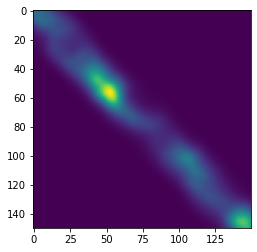

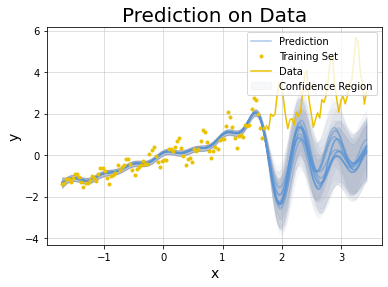

In [5]:
temp_rmse = optimize_nonstatFKL(ess_iters = 25, optim_iters= 10,
                                nomg = 150, lr_init =0.001,
                                iters = 5,period_factor=24,display_plot=True)
